# L2 Fast Gradient Method (FGM)
\
$\eta = \epsilon \, \nabla_x L(\theta, x, y)$ <br>

$\eta \ldots$ perturbation <br>
$\epsilon \ldots$ step size <br>
$x \ldots$ input <br>
$y \ldots$ target <br>
$\theta \ldots$ parameters <br>
$L \ldots$ loss function

In [1]:
import torch, pickle, argparse
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet
from data_loader import load_train_data, load_test_data
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import L2FastGradientAttack
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack, run_batched_attack_cpu, batched_accuracy

In [2]:
total = 10000
bs=100

In [3]:
filename = 'first_tests.pickle'

with open(filename, 'rb') as file:
    loaded = pickle.load(file)
    
data = np.array(loaded[0][0]).reshape(3,6,3,2)
hparams = argparse.Namespace(**data[2,-1,1,1])


TEST_PATH = "s2_mnist.gz"
TRAIN_PATH = "s2_mnist_train_dwr_10000.gz"

train_data = load_train_data(TRAIN_PATH)
test_data = load_test_data(TEST_PATH)

images = test_data[:total][0]
labels = test_data[:total][1]


model = ConvNet(hparams, train_data, test_data).eval()
trainer = pl.Trainer(gpus=1, logger=False)
best_model = torch.load('checkpoints/epoch=17_v6.ckpt')
model.load_state_dict(best_model['state_dict'])

fmodel = PyTorchModel(model, bounds=(0, 255))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
attack = L2FastGradientAttack(random_start=False)
epsilons = [0.1, 0.5, 1, 5, 10, 20, 30, 50, 80, 100, 200, 1e3, 2e3, 5e3]

raw_advs_cpu, clipped_advs_cpu, success_cpu = run_batched_attack_cpu(attack, fmodel, images, labels, epsilons, bs)

clean_accuracy = batched_accuracy(fmodel, images, labels, bs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
success_rate = ep.astensor(success_cpu).float32().mean(axis=-1).raw.cpu()

robust_accuracy = 1 - success_rate
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.1   : 97.5 %
  Linf norm ≤ 0.5   : 97.4 %
  Linf norm ≤ 1     : 97.2 %
  Linf norm ≤ 5     : 95.7 %
  Linf norm ≤ 10    : 93.9 %
  Linf norm ≤ 20    : 90.9 %
  Linf norm ≤ 30    : 88.6 %
  Linf norm ≤ 50    : 85.6 %
  Linf norm ≤ 80    : 82.0 %
  Linf norm ≤ 100   : 80.3 %
  Linf norm ≤ 200   : 73.4 %
  Linf norm ≤ 1000.0: 27.6 %
  Linf norm ≤ 2000.0: 15.5 %
  Linf norm ≤ 5000.0: 11.5 %


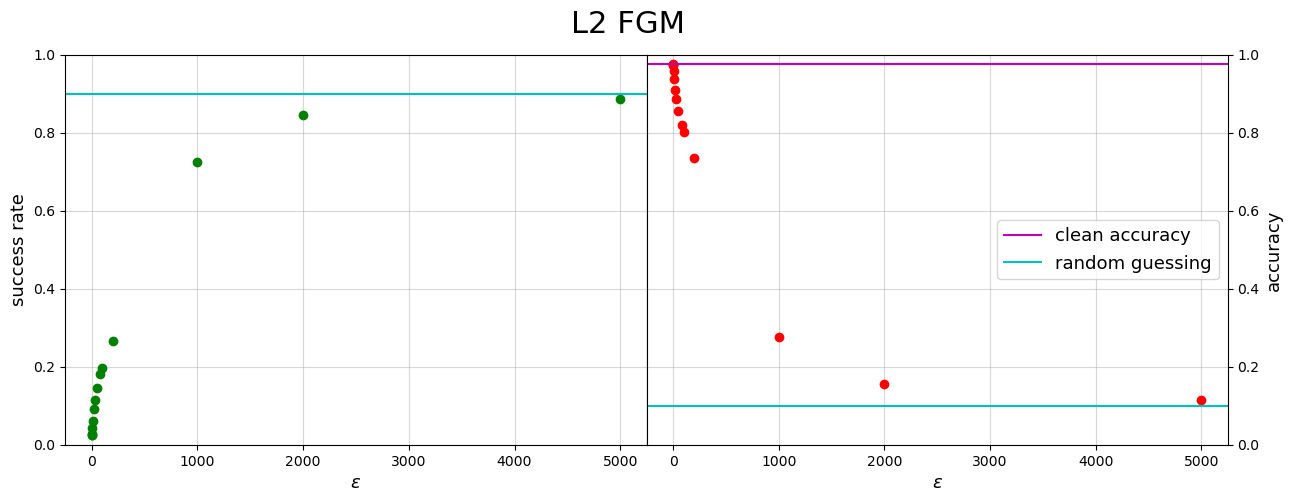

In [6]:
fontsize = 13

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), gridspec_kw = {'wspace':0., 'hspace':0.})
fig.suptitle('L2 FGM', fontsize=22)
plt.subplots_adjust(top=0.89)
axs[0].plot(epsilons, success_rate, 'og')
axs[0].set_ylabel('success rate', fontsize=fontsize)
axs[0].axhline(y=0.9, color='c')
axs[1].plot(epsilons, robust_accuracy, 'or')
axs[1].axhline(y=clean_accuracy, color='m', label='clean accuracy')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('accuracy', fontsize=fontsize)
axs[1].axhline(y=0.1, color='c', label='random guessing')
for j in range(2):
    axs[j].set_xlabel(r'$\epsilon$', fontsize=fontsize)
    axs[j].set_ylim([0,1])
    axs[j].grid(alpha=0.5)

axs[1].legend(fontsize=fontsize)

plt.show()

Since the images are $ 60 \times 60$, a vector that is used in the FGSM (with an infinity norm of one), has an $L_2$ norm of $60$.

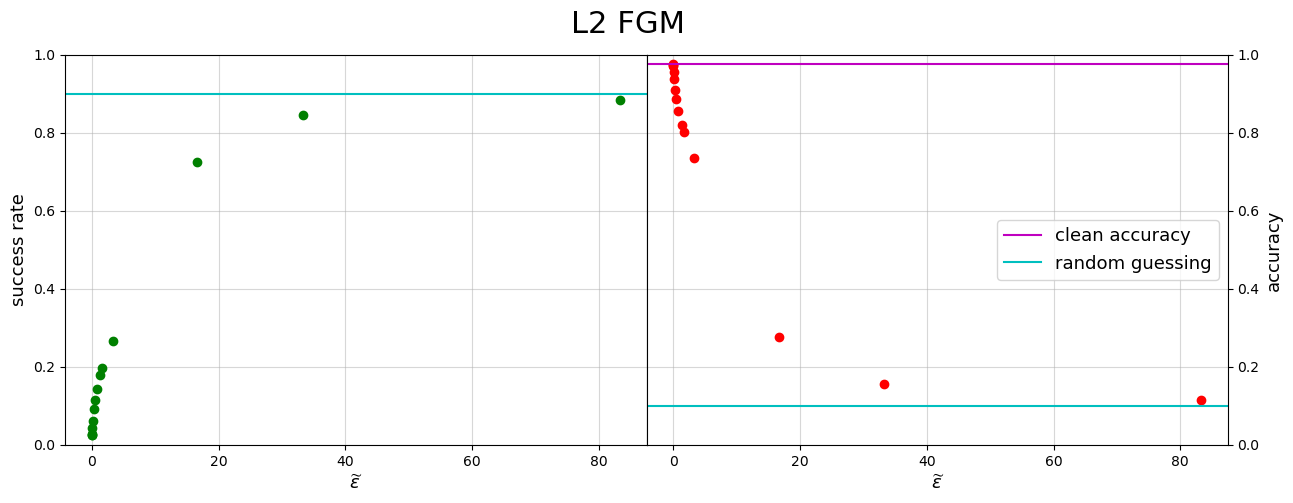

In [12]:
rescaled_epsilons = np.array(epsilons)/60

fontsize = 13

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), gridspec_kw = {'wspace':0., 'hspace':0.})
fig.suptitle('L2 FGM', fontsize=22)
plt.subplots_adjust(top=0.89)
axs[0].plot(rescaled_epsilons, success_rate, 'og')
axs[0].set_ylabel('success rate', fontsize=fontsize)
axs[0].axhline(y=0.9, color='c')
axs[1].plot(rescaled_epsilons, robust_accuracy, 'or')
axs[1].axhline(y=clean_accuracy, color='m', label='clean accuracy')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('accuracy', fontsize=fontsize)
axs[1].axhline(y=0.1, color='c', label='random guessing')
for j in range(2):
    axs[j].set_xlabel(r'$\widetilde{\epsilon}$', fontsize=fontsize)
    axs[j].set_ylim([0,1])
    axs[j].grid(alpha=0.5)

axs[1].legend(fontsize=fontsize)

plt.show()